## Importing Libraries

In [13]:
# Import basic data science packages
import numpy as np
import pandas as pd

# Import tensorflow packages
import tensorflow as tf
from tensorflow.test import gpu_device_name

# Import various keras tools
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#### Run this cell when working locally. When using Colab, the import of this library is handled in the next section.

In [ ]:
# pcamlib.py is my library of helper functions
import pcamlib

---

## Google Colab Setup. When running locally, skip these cells

These cells adapted from code located [here](https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228)

In [3]:
device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [5]:
# Change to capstone folder and print directory to confirm
%cd /content/drive/MyDrive/BrainStation\ Capstone\ Project/capstone
%pwd

/content/drive/MyDrive/BrainStation Capstone Project/capstone


'/content/drive/MyDrive/BrainStation Capstone Project/capstone'

In [6]:
#import pcamlib to Google Colab
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

In [ ]:
# Attempting to load pcam directly from a folder in Google Drive..
# Works locally, doesn't currently work on Colab. May be a version issue
directory = '/content/drive/My Drive/BrainStation Capstone Project/tensorflow_datasets'
pcam, pcam_info = tfds.load("patch_camelyon", data_dir=directory, with_info=True, download=False)

---

## Data Set-up

To get started with this dataset, I adapted the code from this [article](https://geertlitjens.nl/post/getting-started-with-camelyon/) written by Geert Litjens, one of the authors of the dataset.

I used his code for the `train_pipeline`, `valid_pipeline`, and `test_pipeline`, which load the train, validation, and test sets and prepare them for modelling. I also make use of his function `convert_sample`. This function extracts each image and its corresponding label from the dataset, converts each image to a TensorFlow `tf.float32` datatype, then performs one-hot encoding on the labels and converts them to `tf.float32` as well.

In [7]:
# Load dataset and dataset info 
# This step takes about 15-20 minutes on Colab because it has to download the dataset first
pcam, pcam_info = pcamlib.load_pcam()

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteBW07H5/patch_camelyon-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteBW07H5/patch_camelyon-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteBW07H5/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
      

In [8]:
# Create generator "pipelines" for train, validation and test sets.
# Default batch sizes of 64 for the train set and 128 for validation and test sets to speed up calculations
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

---

## Modelling

### If you are not training this model and are loading it from a file, skip ahead to Loading the Model

I also used Geert Litjens CNN layer architecture as a starting point. It resembles a VGG16 architecture because it has three sets of two Convolutional layers followed by a single Max Pooling layer, followed by a Flattening layer and two Dense layers before the final Dense layer which outputs the class predictions. I kept the layer parameters the same as his example.

I changed the optimizer to `Adam` from `SGD` simply because he provided multiple hyperparameters to go along with it, and I wanted to experiment with that on my own. I also added additional Dropout layers after each convolutional layer, because the first iteration of the model started overfitting quickly after the first epoch and the validation accuracy didn't improve beyond 80%.

In [27]:
# Instantiate model object
cnn = Sequential()

# Images are 96x96 px, in RGB so there are 3 channels
image_shape = (96, 96, 3)

# Adding convultional layers to the model 
# It was important to add dropout layers after each convolutional layer to reduce overfitting
cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=image_shape))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.2))

# Add a max pool layer to reduce the dimensions of the feature maps
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))

# Repeating this architecture two more times
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.2))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
     
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.2))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))

# Flatten the data to prepare for dense layers
cnn.add(Flatten())
        
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.2))

cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.2))

# # This extra layer is cnn1.2
# cnn.add(Dense(64, activation='relu'))
# cnn.add(Dropout(0.25))

# Final Dense layer to make class predictions
cnn.add(Dense(2, activation='softmax'))
        
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 94, 94, 16)        448       
_________________________________________________________________
dropout_8 (Dropout)          (None, 94, 94, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 92, 92, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
dropout_10 (Dropout)         (None, 44, 44, 32)       

In [28]:
# For comparison, this commented line is the original optimizer used in the article:
# sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
cnn.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add early stop callback to prevent the model from overfitting, or running too long
# This will stop the training early if the validation loss doesn't not decrease within 3 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

In [29]:
%%time
history = cnn.fit(train_pipeline,
                   validation_data=valid_pipeline,
                   verbose=1, epochs=30, steps_per_epoch=4096, validation_steps=256,
                   callbacks=[early_stop])

Epoch 1/30
4096/4096 [==============================] - 239s 58ms/step - loss: 0.4231 - accuracy: 0.8073 - val_loss: 0.3864 - val_accuracy: 0.8158
Epoch 2/30
4096/4096 [==============================] - 235s 57ms/step - loss: 0.3187 - accuracy: 0.8650 - val_loss: 0.3554 - val_accuracy: 0.8336
Epoch 3/30
4096/4096 [==============================] - 233s 57ms/step - loss: 0.2795 - accuracy: 0.8856 - val_loss: 0.3473 - val_accuracy: 0.8459
Epoch 4/30
4096/4096 [==============================] - 229s 56ms/step - loss: 0.2558 - accuracy: 0.8970 - val_loss: 0.3043 - val_accuracy: 0.8705
Epoch 5/30
4096/4096 [==============================] - 233s 57ms/step - loss: 0.2405 - accuracy: 0.9043 - val_loss: 0.2966 - val_accuracy: 0.8733
Epoch 6/30
4096/4096 [==============================] - 229s 56ms/step - loss: 0.2281 - accuracy: 0.9099 - val_loss: 0.2926 - val_accuracy: 0.8734
Epoch 7/30
4096/4096 [==============================] - 234s 57ms/step - loss: 0.2197 - accuracy: 0.9141 - val_loss: 0

In [30]:
# Save the history of the model to a pandas dataframe
hist_df = pd.DataFrame(history.history)

---

## Saving Model and History

In [14]:
# Save the fitted model to a file
cnn.save('data/models/cnn1.1')

INFO:tensorflow:Assets written to: data/models/cnn1.1/assets


INFO:tensorflow:Assets written to: data/models/cnn1.1/assets


In [17]:
# Save the history of the model to a csv
pcamlib.save_history(hist_df, 'data/models/history/cnn1.1_history.csv')

---

## Loading the Model

In [ ]:
# Load the model from a file
cnn = tf.keras.models.load_model("data/models/cnn1.1")

In [ ]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/cnn1.1_history.csv')

In [ ]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/y_proba/cnn1.1_y_proba.csv')

---

## Analysis

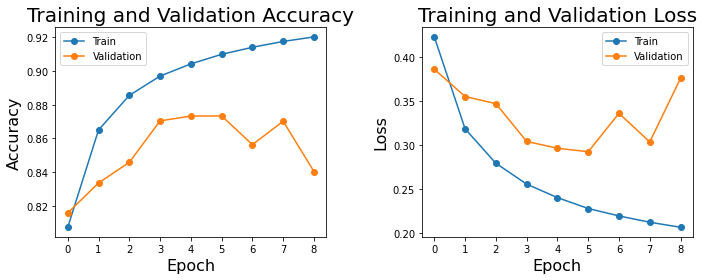

In [31]:
# Plot the training and validation Accuracy and Loss
pcamlib.plot_history(hist_df)

In [32]:
%%time

# Generate y_proba
y_proba = pcamlib.generate_y_proba(cnn, test_pipeline, class_1=False, save=False)

CPU times: user 19.9 s, sys: 2.37 s, total: 22.3 s
Wall time: 41.1 s


In [33]:
%%time

# Get predictions from y_proba. Default threshold of 0.5, meaning predicts positive class if >= 50% certainty of class 1 
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 14.6 ms


In [34]:
%%time

# Create a list of the true labels for the test set
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 23.1 s, sys: 1.97 s, total: 25.1 s
Wall time: 20.5 s


In [35]:
%%time

# Calculate accuracy of the predictions on the test set
pcamlib.print_test_accuracy(y_true, y_pred)

0.781219482421875
CPU times: user 3.94 ms, sys: 9 µs, total: 3.95 ms
Wall time: 4.1 ms


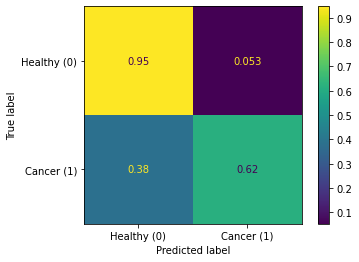

In [36]:
# Plot the confusion matrix
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True)

In [37]:
# Print the classification report to see precision, recall, and f1 score
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.7113    0.9469    0.8124     16391
           1     0.9205    0.6154    0.7376     16377

    accuracy                         0.7812     32768
   macro avg     0.8159    0.7811    0.7750     32768
weighted avg     0.8159    0.7812    0.7750     32768



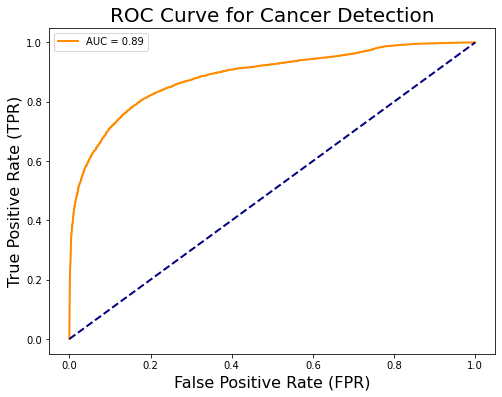

Area under curve (AUC):0.886987442010584
(9563,)
(9563,)


In [38]:
# Plot the receiver operating characteristic curve
pcamlib.plot_roc_curve(y_true, y_proba)

4
10
12
14
15
19
24
26
28


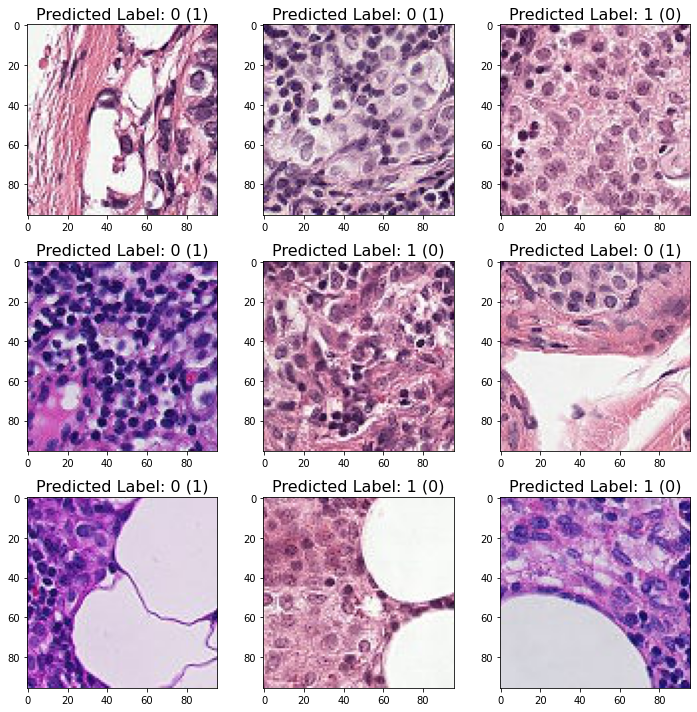

In [39]:
# Show a sample of images that were misclassified
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)

## Summary

Training and prediction times calculated in Google Colab Pro with GPU acceleration. These times can vary based on which GPU is allocated during each runtime.

Note that test accuracy may vary each time the model is trained due to the random nature of the initial weights and the shuffling of the training set. These are meant to be rough estimates. 

Time permitting, I tried to train each version of the model multiple times to establish a range of values for each output. However, I made an effort to save only the best version of each model.

| Model   | Description                                                                                                        | Test Accuracy | AUC       | Training Time | Prediction Time |
|---------|--------------------------------------------------------------------------------------------------------------------|---------------|-----------|---------------|-----------------|
| CNN 1.0 | Base model adapted from Geert Liljens topology.  Added 20% Dropout layers after each Convolutional and Dense layer | 78.1-84.4%    | 0.89-0.91 | 35 minutes    | 41 seconds      |
| CNN 1.1 | Increased dropout to 25%                                                                                           | 83.0-85.4%    | 0.91-0.93 | 31 minutes    | 42 seconds      |